In [14]:
import pandas as pd
from PIL import Image
from IPython.display import display
import numpy as np
def vectorizeImage(image_path):
    # Abre la imagen y la convierte en un vector
    image = Image.open(image_path)
    # Opcional: Redimensionar o convertir a escala de grises si es necesario
    # image = image.resize((ancho_deseado, alto_deseado))
    # image = image.convert('L')  # Para escala de grises
    return np.array(image).flatten().astype(np.uint8)
def splitDataFrames(df_train,df_test,n_train,n_test,random_state=42,proporcion_positiva=0.1,label_col='class_num'):
    # Dividir los dataframes en train y test
    n_positivos = int(n_train*proporcion_positiva)
    n_negativos = n_train-n_positivos
    df_train_positivo = df_train[df_train[label_col]==1]
    df_train_negativo = df_train[df_train[label_col]==0]
    df_test_positivo = df_test[df_test[label_col]==1]
    df_test_negativo = df_test[df_test[label_col]==0]
    # Dividir los dataframes en train y test
    df_train_positivo = df_train_positivo.sample(n=n_positivos,random_state=random_state)
    df_train_negativo = df_train_negativo.sample(n=n_negativos,random_state=random_state)
    n_positivos = int(n_test*proporcion_positiva)
    n_negativos = n_test-n_positivos
    df_test_positivo = df_test_positivo.sample(n=n_positivos,random_state=random_state)
    df_test_negativo = df_test_negativo.sample(n=n_negativos,random_state=random_state)
    # Concatenar los dataframes
    df_train = pd.concat([df_train_positivo,df_train_negativo],ignore_index=True)
    df_test = pd.concat([df_test_positivo,df_test_negativo],ignore_index=True)
    return df_train,df_test

df_train = pd.read_csv('../../datasets/covid/datos_redimensionados_entrenamiento.txt',sep=' ')
df_test = pd.read_csv('../../datasets/covid/datos_redimensionados_prueba.txt',sep=' ')
df_train['class_num'] = df_train['class'].apply(lambda x: 1 if x == 'positive' else 0)
df_test['class_num'] = df_test['class'].apply(lambda x: 1 if x == 'positive' else 0)
N = 1000
N_TEST = 1000

## PCA

In [15]:
df_ent_red, df_pru_red = splitDataFrames(df_train, df_test, N, N_TEST, proporcion_positiva=0.5, random_state=0)

In [16]:
X_train = np.array([vectorizeImage(file) for file in df_ent_red['path_redimensionada'].values])
y_train = df_ent_red['class_num'].values

In [17]:
X_test = np.array([vectorizeImage(file) for file in df_pru_red['path_redimensionada'].values])
y_test = df_pru_red['class_num'].values

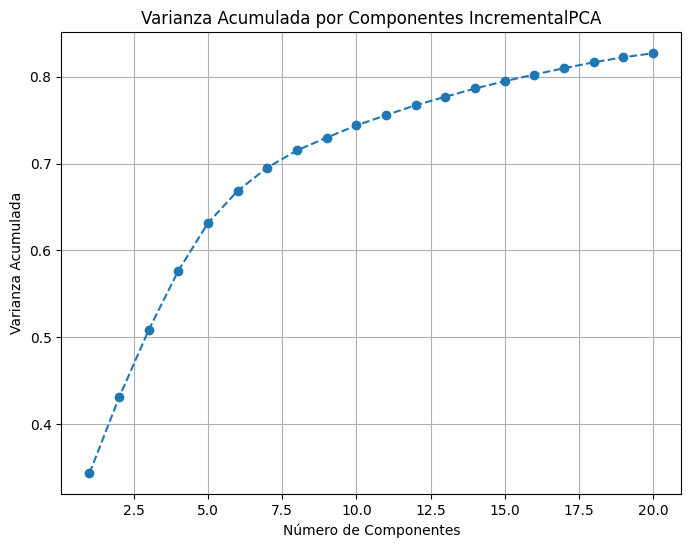

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA

# Cargar un conjunto de datos de ejemplo

# Definir el tamaño del lote
batch_size = 100

# Inicializar IncrementalPCA con el número de componentes deseados
n_components = 20
ipca = IncrementalPCA(n_components=n_components)

# Número total de muestras
n_samples = X_train.shape[0]

# Ajustar el modelo por lotes
for i in range(0, n_samples, batch_size):
    end = i + batch_size
    if end > n_samples:
        end = n_samples
    ipca.partial_fit(X_train[i:end])

# Transformar los datos completos utilizando el modelo ajustado
X_transformed = ipca.transform(X_train)

# Mostrar la proporción de varianza explicada por cada componente
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Graficar la varianza acumulada+
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Acumulada por Componentes IncrementalPCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

km = KMeans(n_clusters=2)
km.fit(X_transformed)
y_pred_test = km.predict(ipca.transform(X_test))
a = accuracy_score(y_test, y_pred_test)
print('Accuracy:', a)

Accuracy: 0.307


In [22]:
from sklearn.metrics import confusion_matrix
matriz_confusion = confusion_matrix(y_test, y_pred_test)
print(matriz_confusion)

[[212 288]
 [405  95]]


: 